In [ ]:
# google drive. so we have to monunt
from google.colab import drive # /content/drive/MyDrive/project/MachineLearning/dataset/mnist.pkl
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
import matplotlib
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sys
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
from glob import glob 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#Keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.optimizers import Adam, Adamax, Adadelta, Nadam, RMSprop
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras import backend as K
#sklearn helpers
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v3 import MobileNetV3, MobileNetV3Large, MobileNetV3Small
from keras.applications.resnet_v2 import ResNet152V2, ResNet50V2, ResNet101V2
from keras.applications.densenet import DenseNet201, DenseNet169, DenseNet121, DenseNet121
from keras.applications.resnet import ResNet50, ResNet101, ResNet152
from keras.applications.efficientnet import EfficientNetB7, EfficientNetB6
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16

In [ ]:
#Download the file and save it in a temporary placeholder '/tmp'
!wget --no-check-certificate \
  https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip \
  -O /tmp/cassavaleafdata.zip

#Unzip the file in '/tmp'
local_zip = '/tmp/cassavaleafdata.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

#Split the data into train, valid, test folders
base_dir = '/tmp/cassavaleafdata'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

--2021-12-07 04:11:46--  https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 2607:f8b0:4023:c0b::80, 2607:f8b0:4023:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1354096203 (1.3G) [application/octet-stream]
Saving to: ‘/tmp/cassavaleafdata.zip’

/tmp/cassavaleafdat 100%[===================>]   1.26G  81.1MB/s    in 18s     

2021-12-07 04:12:05 (70.5 MB/s) - ‘/tmp/cassavaleafdata.zip’ saved [1354096203/1354096203]



In [ ]:
def preprocess(directory):
  '''
  Return the standardized format of all the 
  images in a given directory (ex: 'train', 'test', 'valid')
  '''
  image_files = list(paths.list_images(directory))
  #data and label placeholders
  arrays, labels = [], []
  cnt = 0
  for img in image_files:
    #find the label of the file
    label = img.split('/')[-2]
    # standardize the images: convert to RGB & resize to (224, 224)
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    #add the image and label to the place holders
    arrays.append(image)
    labels.append(label)
    cnt += 1
  #convert these to numpy arrays  
  arrays = np.array(arrays, dtype="float32")
  labels = np.array(labels)
 
  return arrays, labels

In [ ]:
#a placeholder for training data and the training labels
train_data, train_labels = preprocess(train_dir)
#a placeholder for validation (dev) data and the validation (dev) labels
valid_data, valid_labels = preprocess(valid_dir)
#a placeholder for test data and the test labels
test_data, test_labels = preprocess(test_dir)

In [ ]:
Binarizer = LabelBinarizer()
train_y = Binarizer.fit_transform(train_labels)
valid_y = Binarizer.transform(valid_labels)
test_y = Binarizer.transform(test_labels)

In [ ]:
#shuffling the training data
train_indx = np.arange(len(train_labels))
np.random.shuffle(train_indx)
train_data, train_y = train_data[train_indx], train_y[train_indx]

In [ ]:
#rescaling the images such that the pixel values are between one and zero
train_data = train_data / 255.
valid_data = valid_data / 255.
test_data = test_data / 255.

In [ ]:
train_augment = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

valid_augment = ImageDataGenerator()

train_augment.fit(train_data)
valid_augment.fit(valid_data)

In [ ]:
baseModel = InceptionV3(weights="imagenet", include_top=False, input_shape = (224, 224, 3)) ## 224, 224 size
#Freeze the Inception V3 layers:
for layer in baseModel.layers:
	layer.trainable = False

x = baseModel.output
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation="softmax")(x)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
baseM = InceptionResNetV2(weights="imagenet", include_top= False, input_shape=(299, 299, 3))
# inceptionResNetV2 model use

for layer in baseM.layers:
	layer.trainable = False

x = baseM.output
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation="softmax")(x)

219070464/219055592 [==============================] - 2s 0us/step


In [ ]:

model = Model(baseM.input, x)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [ ]:
BATCH_SIZE = 64
NEPOCHS = 30
history = model.fit_generator(train_augment.flow(train_data, train_y, batch_size=BATCH_SIZE),
                              epochs = NEPOCHS, 
                              validation_data = valid_augment.flow(valid_data, valid_y),
                              verbose = 1, 
                              steps_per_epoch=(train_data.shape[0] // BATCH_SIZE), 
                              validation_steps=(valid_data.shape[0] // BATCH_SIZE), 
                              callbacks=[learning_rate_reduction, early_stopping])


# inception ResNetV2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
88/88 [==============================] - 278s 3s/step - loss: 1.3199 - acc: 0.5726 - val_loss: 1.2200 - val_acc: 0.6455 - lr: 1.0000e-04
Epoch 2/30
88/88 [==============================] - 232s 3s/step - loss: 0.7615 - acc: 0.7223 - val_loss: 0.8635 - val_acc: 0.7295 - lr: 1.0000e-04
Epoch 3/30
88/88 [==============================] - 233s 3s/step - loss: 0.6114 - acc: 0.7899 - val_loss: 0.5801 - val_acc: 0.8028 - lr: 1.0000e-04
Epoch 4/30
88/88 [==============================] - 232s 3s/step - loss: 0.5151 - acc: 0.8194 - val_loss: 0.5716 - val_acc: 0.8017 - lr: 1.0000e-04
Epoch 5/30
88/88 [==============================] - 232s 3s/step - loss: 0.4262 - acc: 0.8537 - val_loss: 0.4960 - val_acc: 0.8254 - lr: 1.0000e-04
Epoch 6/30
88/88 [==============================] - 232s 3s/step - loss: 0.3741 - acc: 0.8711 - val_loss: 0.5493 - val_acc: 0.8200 - lr: 1.0000e-04
Epoch 7/30
88/88 [==============================] - 232s 3s/step - loss: 0.3239 - acc: 0.8898 - val_loss: 0.5609

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

<Figure size 432x288 with 0 Axes>

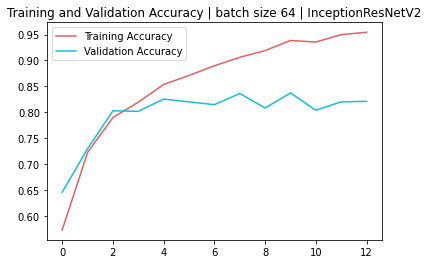

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, color ='#e35f62', label='Training Accuracy')
plt.plot(epochs, val_acc, '#17becf', label='Validation Accuracy')
plt.title('Training and Validation Accuracy | batch size 64 | InceptionResNetV2')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

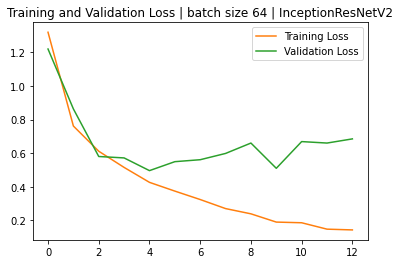

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, '#ff7f0e', label = 'Training Loss')
plt.plot(epochs, val_loss, '#2ca02c', label = 'Validation Loss')
plt.title('Training and Validation Loss | batch size 64 | InceptionResNetV2')
plt.legend()
plt.figure()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_406 (Conv2D)            (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_406 (Batch  (None, 149, 149, 32  96         ['conv2d_406[0][0]']             
 Normalization)                 )                                                             

In [ ]:
#baseM = InceptionResNetV2(weights="imagenet", include_top= False, input_shape=(299, 299, 3))
# Xception model use
baseM2 = Xception(include_top = False, weights="imagenet", input_shape= (299, 299, 3))

for layer in baseM2.layers:
	layer.trainable = False

x = baseM2.output
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation="softmax")(x)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
model = Model(baseM2.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) # adam
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [ ]:
BATCH_SIZE = 64
NEPOCHS = 30
history = model.fit_generator(train_augment.flow(train_data, train_y, batch_size=BATCH_SIZE),
                              epochs = NEPOCHS, 
                              validation_data = valid_augment.flow(valid_data, valid_y),
                              verbose = 1, 
                              steps_per_epoch=(train_data.shape[0] // BATCH_SIZE), 
                              validation_steps=(valid_data.shape[0] // BATCH_SIZE), 
                              callbacks=[learning_rate_reduction, early_stopping])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
88/88 [==============================] - 113s 1s/step - loss: 1.4168 - acc: 0.4887 - val_loss: 1.0513 - val_acc: 0.5991 - lr: 1.0000e-04
Epoch 2/30
88/88 [==============================] - 95s 1s/step - loss: 1.1057 - acc: 0.5837 - val_loss: 0.9852 - val_acc: 0.6444 - lr: 1.0000e-04
Epoch 3/30
88/88 [==============================] - 95s 1s/step - loss: 1.0557 - acc: 0.6021 - val_loss: 0.9492 - val_acc: 0.6498 - lr: 1.0000e-04
Epoch 4/30
88/88 [==============================] - 95s 1s/step - loss: 1.0105 - acc: 0.6153 - val_loss: 0.9665 - val_acc: 0.6573 - lr: 1.0000e-04
Epoch 5/30
88/88 [==============================] - 96s 1s/step - loss: 0.9855 - acc: 0.6325 - val_loss: 0.9135 - val_acc: 0.6713 - lr: 1.0000e-04
Epoch 6/30
88/88 [==============================] - 95s 1s/step - loss: 0.9758 - acc: 0.6305 - val_loss: 0.9284 - val_acc: 0.6455 - lr: 1.0000e-04
Epoch 7/30
88/88 [==============================] - 96s 1s/step - loss: 0.9560 - acc: 0.6468 - val_loss: 0.9055 - val

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

<Figure size 432x288 with 0 Axes>

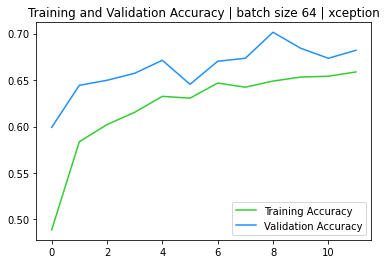

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, color ='limegreen', label='Training Accuracy')
plt.plot(epochs, val_acc, color = 'dodgerblue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy | batch size 64 | xception')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

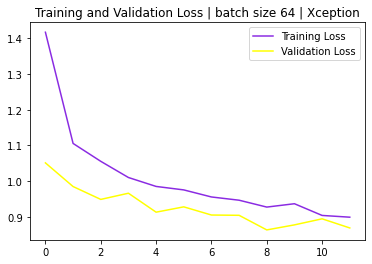

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, color='blueviolet', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'yellow', label = 'Validation Loss')
plt.title('Training and Validation Loss | batch size 64 | Xception')
plt.legend()
plt.figure()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
# Xception
BATCH_SIZE = 64
NEPOCHS = 30
history = model.fit_generator(train_augment.flow(train_data, train_y, batch_size=BATCH_SIZE),
                              epochs = NEPOCHS, 
                              validation_data = valid_augment.flow(valid_data, valid_y),
                              verbose = 1, 
                              steps_per_epoch=(train_data.shape[0] // BATCH_SIZE), 
                              validation_steps=(valid_data.shape[0] // BATCH_SIZE))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
88/88 [==============================] - 95s 1s/step - loss: 0.9197 - acc: 0.6588 - val_loss: 0.8529 - val_acc: 0.7091
Epoch 2/30
88/88 [==============================] - 95s 1s/step - loss: 0.9000 - acc: 0.6597 - val_loss: 0.8630 - val_acc: 0.6940
Epoch 3/30
88/88 [==============================] - 95s 1s/step - loss: 0.9002 - acc: 0.6559 - val_loss: 0.8397 - val_acc: 0.6929
Epoch 4/30
88/88 [==============================] - 95s 1s/step - loss: 0.8964 - acc: 0.6647 - val_loss: 0.8756 - val_acc: 0.7015
Epoch 5/30
88/88 [==============================] - 95s 1s/step - loss: 0.8866 - acc: 0.6672 - val_loss: 0.8642 - val_acc: 0.6875
Epoch 6/30
88/88 [==============================] - 95s 1s/step - loss: 0.8890 - acc: 0.6695 - val_loss: 0.8474 - val_acc: 0.6821
Epoch 7/30
88/88 [==============================] - 95s 1s/step - loss: 0.8882 - acc: 0.6690 - val_loss: 0.8420 - val_acc: 0.6950
Epoch 8/30
88/88 [==============================] - 94s 1s/step - loss: 0.8777 - acc: 0.67

In [ ]:
# any more can't trainning

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

<Figure size 432x288 with 0 Axes>

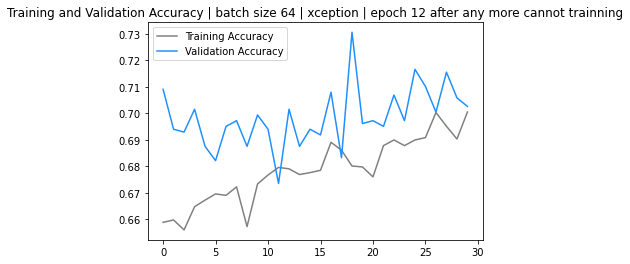

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, color ='gray', label='Training Accuracy')
plt.plot(epochs, val_acc, color = 'dodgerblue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy | batch size 64 | xception | epoch 12 after any more cannot trainning')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

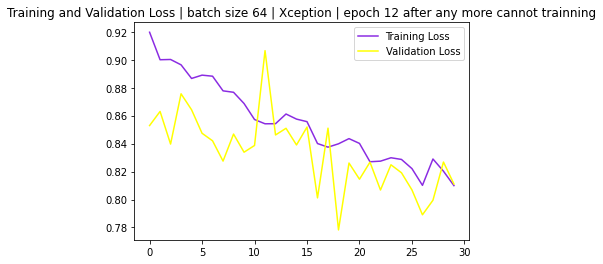

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, color='blueviolet', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'yellow', label = 'Validation Loss')
plt.title('Training and Validation Loss | batch size 64 | Xception | epoch 12 after any more cannot trainning')
plt.legend()
plt.figure()

In [ ]:
baseM3 = DenseNet201(weights="imagenet", include_top=False, input_shape = (224, 224, 3)) ## 224, 224 size
#Freeze the DenseNet201 layers:
for layer in baseM3.layers:
	layer.trainable = False

x = baseM3.output
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation="softmax")(x)

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
model = Model(baseM3.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) # adam
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [ ]:
BATCH_SIZE = 64
NEPOCHS = 30
history = model.fit_generator(train_augment.flow(train_data, train_y, batch_size=BATCH_SIZE),
                              epochs = NEPOCHS, 
                              validation_data = valid_augment.flow(valid_data, valid_y),
                              verbose = 1, 
                              steps_per_epoch=(train_data.shape[0] // BATCH_SIZE), 
                              validation_steps=(valid_data.shape[0] // BATCH_SIZE), 
                              callbacks=[learning_rate_reduction, early_stopping])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
88/88 [==============================] - 130s 1s/step - loss: 2.2796 - acc: 0.4197 - val_loss: 1.0430 - val_acc: 0.6024 - lr: 1.0000e-04
Epoch 2/30
88/88 [==============================] - 100s 1s/step - loss: 1.2737 - acc: 0.5370 - val_loss: 0.9675 - val_acc: 0.6347 - lr: 1.0000e-04
Epoch 3/30
88/88 [==============================] - 99s 1s/step - loss: 1.1203 - acc: 0.5823 - val_loss: 0.9007 - val_acc: 0.6584 - lr: 1.0000e-04
Epoch 4/30
88/88 [==============================] - 100s 1s/step - loss: 1.0653 - acc: 0.6030 - val_loss: 0.8570 - val_acc: 0.6789 - lr: 1.0000e-04
Epoch 5/30
88/88 [==============================] - 100s 1s/step - loss: 1.0239 - acc: 0.6100 - val_loss: 0.8475 - val_acc: 0.6800 - lr: 1.0000e-04
Epoch 6/30
88/88 [==============================] - 99s 1s/step - loss: 1.0082 - acc: 0.6254 - val_loss: 0.8538 - val_acc: 0.6789 - lr: 1.0000e-04
Epoch 7/30
88/88 [==============================] - 99s 1s/step - loss: 0.9760 - acc: 0.6379 - val_loss: 0.8469 - 

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

<Figure size 432x288 with 0 Axes>

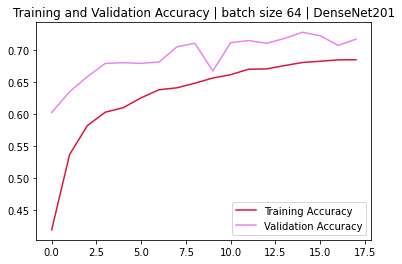

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, color ='crimson', label='Training Accuracy')
plt.plot(epochs, val_acc, color = 'violet', label='Validation Accuracy')
plt.title('Training and Validation Accuracy | batch size 64 | DenseNet201')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

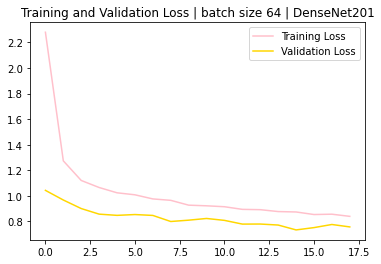

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, color='pink', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'gold', label = 'Validation Loss')
plt.title('Training and Validation Loss | batch size 64 | DenseNet201')
plt.legend()
plt.figure()

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
y_pred = model.predict(test_data)

([<matplotlib.axis.YTick at 0x7fc8d75b8550>,
 <a list of 5 Text major ticklabel objects>)

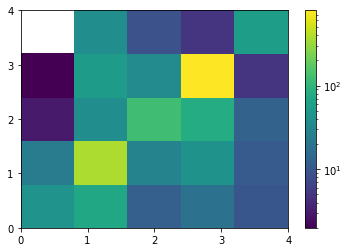

In [ ]:
from matplotlib.colors import LogNorm
plt.hist2d(y_pred.argmax(axis = 1), test_y.argmax(axis =1), bins = 5, density=False, norm = LogNorm())
plt.colorbar()
plt.xticks([0,1,2,3,4])
plt.yticks([0,1,2,3,4])

In [ ]:
confusion_matrix(y_pred.argmax(axis = 1), test_y.argmax(axis =1))

array([[ 43,  24,   3,   2,   0],
       [ 71, 376,  37,  53,  37],
       [ 12,  29, 126,  34,   9],
       [ 19,  41,  79, 792,   5],
       [ 10,  11,  13,   5,  54]])

In [ ]:
unique_labels = Binarizer.inverse_transform(np.eye(5))
report = classification_report(test_y.argmax(axis = 1), 
                      y_pred.argmax(axis = 1), 
                      labels = [0,1,2,3,4], 
                      target_names = unique_labels)

In [ ]:
print(report)

              precision    recall  f1-score   support

         cbb       0.60      0.28      0.38       155
        cbsd       0.66      0.78      0.71       481
         cgm       0.60      0.49      0.54       258
         cmd       0.85      0.89      0.87       886
     healthy       0.58      0.51      0.55       105

    accuracy                           0.74      1885
   macro avg       0.66      0.59      0.61      1885
weighted avg       0.73      0.74      0.73      1885



In [ ]:
# ResNet_V2 model / ResNet152V2
baseM4 = ResNet152V2(weights="imagenet", include_top=False, input_shape = (224, 224, 3)) ## 224, 224 size

for layer in baseM4.layers:
	layer.trainable = False

x = baseM4.output
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation="softmax")(x)

234561536/234545216 [==============================] - 3s 0us/step


In [ ]:
model = Model(baseM4.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) # adam
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [ ]:
BATCH_SIZE = 64
NEPOCHS = 30
history = model.fit_generator(train_augment.flow(train_data, train_y, batch_size=BATCH_SIZE),
                              epochs = NEPOCHS, 
                              validation_data = valid_augment.flow(valid_data, valid_y),
                              verbose = 1, 
                              steps_per_epoch=(train_data.shape[0] // BATCH_SIZE), 
                              validation_steps=(valid_data.shape[0] // BATCH_SIZE), 
                              callbacks=[learning_rate_reduction, early_stopping]) # ResNet v2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
88/88 [==============================] - 136s 1s/step - loss: 4.1542 - acc: 0.4455 - val_loss: 1.4055 - val_acc: 0.5614 - lr: 1.0000e-04
Epoch 2/30
88/88 [==============================] - 117s 1s/step - loss: 1.7821 - acc: 0.5057 - val_loss: 1.1463 - val_acc: 0.5841 - lr: 1.0000e-04
Epoch 3/30
88/88 [==============================] - 117s 1s/step - loss: 1.3257 - acc: 0.5383 - val_loss: 1.0275 - val_acc: 0.6110 - lr: 1.0000e-04
Epoch 4/30
88/88 [==============================] - 117s 1s/step - loss: 1.1816 - acc: 0.5710 - val_loss: 0.9728 - val_acc: 0.6390 - lr: 1.0000e-04
Epoch 5/30
88/88 [==============================] - 117s 1s/step - loss: 1.1437 - acc: 0.5735 - val_loss: 0.9679 - val_acc: 0.6476 - lr: 1.0000e-04
Epoch 6/30
88/88 [==============================] - 117s 1s/step - loss: 1.1059 - acc: 0.5910 - val_loss: 1.0061 - val_acc: 0.6347 - lr: 1.0000e-04
Epoch 7/30
88/88 [==============================] - 118s 1s/step - loss: 1.0696 - acc: 0.5957 - val_loss: 0.9454

In [ ]:
import matplotlib.pyplot as plt  
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # 

<Figure size 432x288 with 0 Axes>

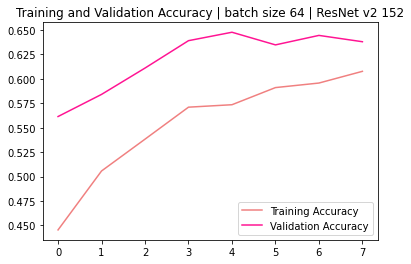

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, color ='lightcoral', label='Training Accuracy')
plt.plot(epochs, val_acc, color = 'deeppink', label='Validation Accuracy')
plt.title('Training and Validation Accuracy | batch size 64 | ResNet v2 152')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

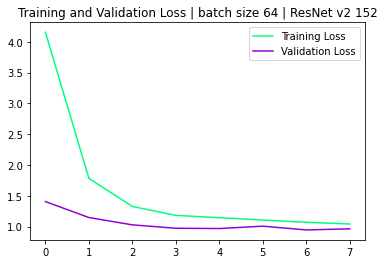

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, color='springgreen', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'darkviolet', label = 'Validation Loss')
plt.title('Training and Validation Loss | batch size 64 | ResNet v2 152')
plt.legend()
plt.figure()

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# MoblieNet V2
baseM5 = MobileNetV2(weights="imagenet", include_top=False, input_shape = (224, 224, 3)) ## 224, 224 size
for layer in baseM5.layers:
	layer.trainable = False

x = baseM5.output
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation="softmax")(x)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
model = Model(baseM5.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) # adam
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [ ]:
BATCH_SIZE = 64
NEPOCHS = 30
history = model.fit_generator(train_augment.flow(train_data, train_y, batch_size=BATCH_SIZE),
                              epochs = NEPOCHS, 
                              validation_data = valid_augment.flow(valid_data, valid_y),
                              verbose = 1, 
                              steps_per_epoch=(train_data.shape[0] // BATCH_SIZE), 
                              validation_steps=(valid_data.shape[0] // BATCH_SIZE), 
                              callbacks=[learning_rate_reduction, early_stopping])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
88/88 [==============================] - 208s 2s/step - loss: 3.1725 - acc: 0.4015 - val_loss: 1.1303 - val_acc: 0.5938 - lr: 1.0000e-04
Epoch 2/30
88/88 [==============================] - 201s 2s/step - loss: 1.3589 - acc: 0.5190 - val_loss: 1.0064 - val_acc: 0.6110 - lr: 1.0000e-04
Epoch 3/30
88/88 [==============================] - 201s 2s/step - loss: 1.1739 - acc: 0.5504 - val_loss: 0.9730 - val_acc: 0.6282 - lr: 1.0000e-04
Epoch 4/30
88/88 [==============================] - 201s 2s/step - loss: 1.1171 - acc: 0.5640 - val_loss: 0.9485 - val_acc: 0.6444 - lr: 1.0000e-04
Epoch 5/30
88/88 [==============================] - 201s 2s/step - loss: 1.0771 - acc: 0.5894 - val_loss: 0.8953 - val_acc: 0.6659 - lr: 1.0000e-04
Epoch 6/30
88/88 [==============================] - 200s 2s/step - loss: 1.0479 - acc: 0.6007 - val_loss: 0.8983 - val_acc: 0.6595 - lr: 1.0000e-04
Epoch 7/30
88/88 [==============================] - 201s 2s/step - loss: 1.0343 - acc: 0.5967 - val_loss: 0.8170

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

<Figure size 432x288 with 0 Axes>

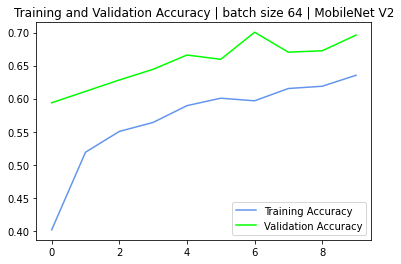

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, color ='cornflowerblue', label='Training Accuracy')
plt.plot(epochs, val_acc, color = 'lime', label='Validation Accuracy')
plt.title('Training and Validation Accuracy | batch size 64 | MobileNet V2')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

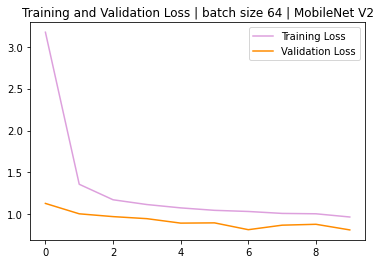

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, color= 'plum', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'darkorange', label = 'Validation Loss')
plt.title('Training and Validation Loss | batch size 64 | MobileNet V2')
plt.legend()
plt.figure()

In [ ]:
for layer in baseModel.layers:
    layer.trainable = True

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [ ]:
BATCH_SIZE = 64
NEPOCHS = 30
history = model.fit_generator(train_augment.flow(train_data, train_y, batch_size=BATCH_SIZE),
                              epochs = NEPOCHS, 
                              validation_data = valid_augment.flow(valid_data, valid_y),
                              verbose = 1, 
                              steps_per_epoch=(train_data.shape[0] // BATCH_SIZE), 
                              validation_steps=(valid_data.shape[0] // BATCH_SIZE), 
                              callbacks=[learning_rate_reduction, early_stopping])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
 1/88 [..............................] - ETA: 42:24 - loss: 0.4953 - acc: 0.8438

KeyboardInterrupt: ignored

In [ ]:
#keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)